In [1]:
# ============================================
# CUSTOMER DATA TO INSIGHT ANALYSIS
# End-to-End Data Analysis Project
# ============================================

%pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# ============================================
# SECTION 1: DATA EXTRACTION & LOADING
# ============================================

print("\n DATA EXTRACTION & LOADING")
print("-" * 60)

# Load raw data from CSV files
from pathlib import Path

# Use existing base_dir if defined, otherwise default
try:
	base_dir
except NameError:
	base_dir = Path('Customer Insight') / 'raw_data'

# Resolve alternative locations if the directory doesn't exist
if not base_dir.exists():
	for candidate in [
		Path('raw_data'),
		Path.cwd() / 'raw_data',
		Path.cwd() / 'Customer Insight' / 'raw_data'
	]:
		if candidate.exists():
			base_dir = candidate
			break

# Validate required files
required_files = ['raw_customers.csv', 'raw_orders.csv', 'raw_payments.csv']
missing_files = [f for f in required_files if not (base_dir / f).exists()]
if missing_files:
	raise FileNotFoundError(
		f"Missing files in '{base_dir}': {', '.join(missing_files)}"
	)

df_customers = pd.read_csv(base_dir / 'raw_customers.csv')
df_orders = pd.read_csv(base_dir / 'raw_orders.csv')
df_payments = pd.read_csv(base_dir / 'raw_payments.csv')

print(f"✓ Loaded {len(df_customers)} customer records")
print(f"✓ Loaded {len(df_orders)} order records")
print(f"✓ Loaded {len(df_payments)} payment records")

# Display sample data
print("\n Sample Customer Data:")
print(df_customers.head(3))
print("\n Sample Order Data:")
print(df_orders.head(3))
print("\n Sample Payment Data:")
print(df_payments.head(3))


 DATA EXTRACTION & LOADING
------------------------------------------------------------
✓ Loaded 100 customer records
✓ Loaded 99 order records
✓ Loaded 113 payment records

 Sample Customer Data:
   id first_name last_name
0   1    Michael        P.
1   2      Shawn        M.
2   3   Kathleen        P.

 Sample Order Data:
   id  user_id  order_date     status
0   1        1  2018-01-01   returned
1   2        3  2018-01-02  completed
2   3       94  2018-01-04  completed

 Sample Payment Data:
   id  order_id payment_method  amount
0   1         1    credit_card    1000
1   2         2    credit_card    2000
2   3         3         coupon     100


In [8]:
# ============================================
# SECTION 2: DATA CLEANING & PREPARATION
# ============================================

print("\n DATA CLEANING & PREPARATION")
print("-" * 60)

# Check for missing values
print("\n Missing Values Analysis:")
print(f"Customers: {df_customers.isnull().sum().sum()} missing values")
print(f"Orders: {df_orders.isnull().sum().sum()} missing values")
print(f"Payments: {df_payments.isnull().sum().sum()} missing values")

# Clean column names
df_customers.columns = df_customers.columns.str.lower().str.strip()
df_orders.columns = df_orders.columns.str.lower().str.strip()
df_payments.columns = df_payments.columns.str.lower().str.strip()

# Rename for clarity
df_customers = df_customers.rename(columns={'id': 'customer_id'})
df_orders = df_orders.rename(columns={'id': 'order_id', 'user_id': 'customer_id'})
df_payments = df_payments.rename(columns={'id': 'payment_id'})

# Convert date column
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])

# Standardize status values
df_orders['status'] = df_orders['status'].str.strip().str.lower()

print("\n✓ Column names standardized")
print("✓ Date columns converted")
print("✓ Status values cleaned")

# Data quality checks
print("\n Data Quality Summary:")
print(f"Customer ID uniqueness: {df_customers['customer_id'].is_unique}")
print(f"Order ID uniqueness: {df_orders['order_id'].is_unique}")
print(f"Order statuses: {df_orders['status'].unique()}")
print(f"Payment methods: {df_payments['payment_method'].unique()}")


 DATA CLEANING & PREPARATION
------------------------------------------------------------

 Missing Values Analysis:
Customers: 0 missing values
Orders: 0 missing values
Payments: 0 missing values

✓ Column names standardized
✓ Date columns converted
✓ Status values cleaned

 Data Quality Summary:
Customer ID uniqueness: True
Order ID uniqueness: True
Order statuses: ['returned' 'completed' 'return_pending' 'shipped' 'placed']
Payment methods: ['credit_card' 'coupon' 'bank_transfer' 'gift_card']


In [9]:
# ============================================
# SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================

print("\n EXPLORATORY DATA ANALYSIS")
print("-" * 60)

# Merge datasets
print("\n Merging datasets...")
df_orders_payments = df_orders.merge(df_payments, on='order_id', how='left')
print(f"✓ Orders + Payments: {len(df_orders_payments)} records")

# Check for orders with multiple payments
orders_with_multiple_payments = df_orders_payments.groupby('order_id').size()
multi_payment_orders = (orders_with_multiple_payments > 1).sum()
print(f"  Orders with multiple payments: {multi_payment_orders}")

# Create aggregated payment data (sum multiple payments per order)
order_payment_totals = df_orders_payments.groupby('order_id').agg({
    'customer_id': 'first',
    'order_date': 'first',
    'status': 'first',
    'amount': 'sum'  # Sum all payments for the order
}).reset_index()

print(f"✓ Aggregated to unique orders: {len(order_payment_totals)} records")

# Data Quality Check: Identify zero-revenue orders
zero_revenue_orders = order_payment_totals[order_payment_totals['amount'] == 0]
if len(zero_revenue_orders) > 0:
    print(f"\n Data Quality Alert: {len(zero_revenue_orders)} orders with $0 revenue")
    print(f"   Order IDs: {zero_revenue_orders['order_id'].tolist()}")
    print(f"   These will be excluded from revenue analysis")

# Merge with customers
df_full = order_payment_totals.merge(df_customers, on='customer_id', how='left')
print(f"✓ Full dataset created: {len(df_full)} records (one row per order)")

# Basic statistics
print("\n" + "="*60)
print(" PAYMENT STATISTICS")
print("="*60)
print(df_payments['amount'].describe())
print(f"\nTotal Payments Processed: {len(df_payments)}")
print(f"Total Payment Amount: ${df_payments['amount'].sum():,}")
print(f"Zero-value Payments: {(df_payments['amount'] == 0).sum()}")

# Order Status Distribution
print("\n" + "="*60)
print(" ORDER STATUS DISTRIBUTION")
print("="*60)
status_counts = df_orders['status'].value_counts()
print(status_counts)
print(f"\nCompletion Rate: {(status_counts.get('completed', 0) / len(df_orders) * 100):.1f}%")
return_count = status_counts.get('returned', 0) + status_counts.get('return_pending', 0)
print(f"Return Rate: {(return_count / len(df_orders) * 100):.1f}%")

# Payment Method Analysis
print("\n" + "="*60)
print(" PAYMENT METHOD DISTRIBUTION")
print("="*60)
payment_methods = df_payments['payment_method'].value_counts()
print(payment_methods)
print("\nBreakdown:")
for method, count in payment_methods.items():
    pct = count / len(df_payments) * 100
    print(f"  • {method.replace('_', ' ').title()}: {count} ({pct:.1f}%)")

# Temporal Analysis
df_orders['year_month'] = df_orders['order_date'].dt.to_period('M')
print("\n" + "="*60)
print(" ORDERS BY MONTH")
print("="*60)
monthly_orders = df_orders['year_month'].value_counts().sort_index()
print(monthly_orders)

# Date range
print(f"\nDate Range: {df_orders['order_date'].min().date()} to {df_orders['order_date'].max().date()}")
print(f"Duration: {(df_orders['order_date'].max() - df_orders['order_date'].min()).days} days")

# Customer Behavior
print("\n" + "="*60)
print(" CUSTOMER ORDERING BEHAVIOR")
print("="*60)
orders_per_customer = df_orders.groupby('customer_id').size()
print(f"Total customers with orders: {len(orders_per_customer)}")
print(f"Total customers in database: {len(df_customers)}")
print(f"Customers without orders: {len(df_customers) - len(orders_per_customer)}")
print(f"\nOne-time buyers: {(orders_per_customer == 1).sum()}")
print(f"Repeat customers: {(orders_per_customer > 1).sum()}")
print(f"Max orders by single customer: {orders_per_customer.max()}")
print(f"Average orders per customer: {orders_per_customer.mean():.2f}")

# Multi-payment insights
print("\n" + "="*60)
print(" MULTI-PAYMENT ORDER ANALYSIS")
print("="*60)
print(f"Orders with 1 payment: {(orders_with_multiple_payments == 1).sum()}")
print(f"Orders with 2+ payments: {multi_payment_orders}")
print(f"Average payments per order: {orders_with_multiple_payments.mean():.2f}")

if multi_payment_orders > 0:
    print("\n Example orders with multiple payments:")
    multi_payment_examples = orders_with_multiple_payments[orders_with_multiple_payments > 1].head(3)
    for order_id, payment_count in multi_payment_examples.items():
        order_payments = df_orders_payments[df_orders_payments['order_id'] == order_id]
        total = order_payments['amount'].sum()
        print(f"  • Order #{order_id}: {payment_count} payments, Total: ${total:,}")


 EXPLORATORY DATA ANALYSIS
------------------------------------------------------------

 Merging datasets...
✓ Orders + Payments: 113 records
  Orders with multiple payments: 13
✓ Aggregated to unique orders: 99 records

 Data Quality Alert: 1 orders with $0 revenue
   Order IDs: [65]
   These will be excluded from revenue analysis
✓ Full dataset created: 99 records (one row per order)

 PAYMENT STATISTICS
count     113.000000
mean     1479.646018
std       919.836873
min         0.000000
25%       600.000000
50%      1500.000000
75%      2300.000000
max      3000.000000
Name: amount, dtype: float64

Total Payments Processed: 113
Total Payment Amount: $167,200
Zero-value Payments: 3

 ORDER STATUS DISTRIBUTION
status
completed         67
placed            13
shipped           13
returned           4
return_pending     2
Name: count, dtype: int64

Completion Rate: 67.7%
Return Rate: 6.1%

 PAYMENT METHOD DISTRIBUTION
payment_method
credit_card      55
bank_transfer    33
coupon       

In [10]:
# ============================================
# SECTION 4: STATISTICAL ANALYSIS & CUSTOMER SEGMENTATION
# ============================================

print("\n STATISTICAL ANALYSIS & CUSTOMER SEGMENTATION")
print("-" * 60)

# Filter for completed orders only (revenue-generating)
completed_orders = df_full[df_full['status'] == 'completed'].copy()
print(f"\n Analyzing {len(completed_orders)} completed orders")
print(f"   (Excluding {len(df_full) - len(completed_orders)} non-completed orders)")

# Document customer inclusion/exclusion
total_customers_in_db = len(df_customers)
customers_with_completed_orders = completed_orders['customer_id'].nunique()
print(f"\n Customer Inclusion Analysis:")
print(f"   • Total customers in database: {total_customers_in_db}")
print(f"   • Customers with completed orders: {customers_with_completed_orders}")
print(f"   • Excluded (no completed orders): {total_customers_in_db - customers_with_completed_orders}")
print(f"   • Inclusion rate: {customers_with_completed_orders/total_customers_in_db*100:.1f}%")

# Calculate Customer Lifetime Value (CLV)
customer_metrics = completed_orders.groupby('customer_id').agg({
    'order_id': 'count',
    'amount': 'sum',
    'order_date': ['min', 'max']
}).reset_index()

customer_metrics.columns = ['customer_id', 'total_orders', 'total_revenue', 'first_order', 'last_order']
customer_metrics['avg_order_value'] = customer_metrics['total_revenue'] / customer_metrics['total_orders']
customer_metrics['customer_lifespan_days'] = (customer_metrics['last_order'] - customer_metrics['first_order']).dt.days

# Merge with customer names
customer_metrics = customer_metrics.merge(
    df_customers[['customer_id', 'first_name', 'last_name']], 
    on='customer_id', 
    how='left'
)
customer_metrics['full_name'] = customer_metrics['first_name'] + ' ' + customer_metrics['last_name']

print(f"\n Customer Metrics Created:")
print(f"   • Total customers analyzed: {len(customer_metrics)}")
print(f"   • Total revenue (completed): ${customer_metrics['total_revenue'].sum():,.0f}")

# CLV Statistics
print("\n" + "="*60)
print(" CUSTOMER LIFETIME VALUE (CLV) ANALYSIS")
print("="*60)
print(customer_metrics['total_revenue'].describe())

mean_clv = customer_metrics['total_revenue'].mean()
median_clv = customer_metrics['total_revenue'].median()
std_clv = customer_metrics['total_revenue'].std()

print(f"\n Key CLV Metrics:")
print(f"   • Mean CLV: ${mean_clv:,.2f}")
print(f"   • Median CLV: ${median_clv:,.2f}")
print(f"   • Standard Deviation: ${std_clv:,.2f}")
print(f"   • Min CLV: ${customer_metrics['total_revenue'].min():,.0f}")
print(f"   • Max CLV: ${customer_metrics['total_revenue'].max():,.0f}")

# Customer Segmentation
print("\n" + "="*60)
print(" CUSTOMER SEGMENTATION BY REVENUE")
print("="*60)

# Define segments based on percentiles
q33 = customer_metrics['total_revenue'].quantile(0.33)
q67 = customer_metrics['total_revenue'].quantile(0.67)

customer_metrics['segment'] = pd.cut(
    customer_metrics['total_revenue'], 
    bins=[0, q33, q67, float('inf')], 
    labels=['Low Value', 'Medium Value', 'High Value']
)

print(f"\nSegment Thresholds:")
print(f"   • Low Value: $0 - ${q33:,.0f}")
print(f"   • Medium Value: ${q33:,.0f} - ${q67:,.0f}")
print(f"   • High Value: >${q67:,.0f}")

# Segment Analysis
segment_analysis = customer_metrics.groupby('segment').agg({
    'customer_id': 'count',
    'total_revenue': ['sum', 'mean'],
    'total_orders': 'mean',
    'avg_order_value': 'mean'
}).round(2)

segment_analysis.columns = ['Customer Count', 'Total Revenue', 'Avg CLV', 'Avg Orders', 'Avg Order Value']
print("\n" + segment_analysis.to_string())

# Segment breakdown
total_customers = len(customer_metrics)
total_revenue = customer_metrics['total_revenue'].sum()

print("\n Segment Breakdown:")
for segment in ['Low Value', 'Medium Value', 'High Value']:
    seg_data = customer_metrics[customer_metrics['segment'] == segment]
    count = len(seg_data)
    revenue = seg_data['total_revenue'].sum()
    
    print(f"\n{segment}:")
    print(f"   • Customers: {count} ({count/total_customers*100:.1f}%)")
    print(f"   • Revenue: ${revenue:,.0f} ({revenue/total_revenue*100:.1f}%)")
    print(f"   • Avg CLV: ${seg_data['total_revenue'].mean():,.0f}")

# Pareto Analysis (80/20 Rule)
print("\n" + "="*60)
print(" PARETO ANALYSIS (80/20 RULE)")
print("="*60)

customer_metrics_sorted = customer_metrics.sort_values('total_revenue', ascending=False).reset_index(drop=True)
customer_metrics_sorted['cumulative_revenue'] = customer_metrics_sorted['total_revenue'].cumsum()
customer_metrics_sorted['cumulative_revenue_pct'] = (
    customer_metrics_sorted['cumulative_revenue'] / customer_metrics_sorted['total_revenue'].sum() * 100
)

# Find how many customers account for 80% of revenue
customers_for_80_pct = (customer_metrics_sorted['cumulative_revenue_pct'] <= 80).sum()
top_20_pct_count = int(len(customer_metrics) * 0.2)
revenue_from_top_20 = customer_metrics_sorted.iloc[:top_20_pct_count]['total_revenue'].sum()

print(f"\n Key Findings:")
print(f"   • Top {customers_for_80_pct} customers ({customers_for_80_pct/len(customer_metrics)*100:.1f}%) generate 80% of revenue")
print(f"   • Top 20% ({top_20_pct_count} customers) generate ${revenue_from_top_20:,.0f} ({revenue_from_top_20/total_revenue*100:.1f}%)")

# Correlation Analysis
print("\n" + "="*60)
print(" CORRELATION ANALYSIS")
print("="*60)

correlation_data = customer_metrics[['total_orders', 'total_revenue', 'avg_order_value', 'customer_lifespan_days']].corr()
print("\nCorrelation Matrix:")
print(correlation_data.round(3))

orders_revenue_corr = correlation_data.loc['total_orders', 'total_revenue']
print(f"\n Key Insight:")
print(f"   • Orders vs Revenue correlation: {orders_revenue_corr:.3f}")
if orders_revenue_corr > 0.7:
    print(f"   → STRONG positive correlation: More orders = More revenue")
elif orders_revenue_corr > 0.4:
    print(f"   → MODERATE positive correlation: Orders influence revenue")
else:
    print(f"   → WEAK correlation: Revenue driven by order value, not frequency")

# Top 10 Customers
print("\n" + "="*60)
print(" TOP 10 MOST VALUABLE CUSTOMERS")
print("="*60)

top_10_customers = customer_metrics.nlargest(10, 'total_revenue')[
    ['customer_id', 'full_name', 'total_orders', 'total_revenue', 'avg_order_value', 'segment']
].copy()

top_10_customers.index = range(1, 11)
top_10_customers['total_revenue'] = top_10_customers['total_revenue'].apply(lambda x: f"${x:,.0f}")
top_10_customers['avg_order_value'] = top_10_customers['avg_order_value'].apply(lambda x: f"${x:,.0f}")

print("\n" + top_10_customers.to_string())

top_customer = customer_metrics.nlargest(1, 'total_revenue').iloc[0]
print(f"\n Top Customer: {top_customer['full_name']}")
print(f"   • Total Revenue: ${top_customer['total_revenue']:,.0f}")
print(f"   • Total Orders: {top_customer['total_orders']}")
print(f"   • Contribution: {top_customer['total_revenue']/total_revenue*100:.1f}% of total revenue")

# Payment Method Performance
print("\n" + "="*60)
print(" PAYMENT METHOD PERFORMANCE")
print("="*60)

# Re-merge to get payment methods for completed orders
completed_with_payments = completed_orders.merge(
    df_orders_payments[['order_id', 'payment_method']], 
    on='order_id', 
    how='left'
)

payment_performance = completed_with_payments.groupby('payment_method').agg({
    'amount': ['sum', 'mean', 'count']
}).round(2)

payment_performance.columns = ['Total Revenue', 'Avg Transaction', 'Transaction Count']
payment_performance = payment_performance.sort_values('Total Revenue', ascending=False)

print("\n" + payment_performance.to_string())

top_payment = payment_performance.index[0]
print(f"\n Most Revenue-Generating Method: {top_payment.replace('_', ' ').title()}")
print(f"   • Revenue: ${payment_performance.loc[top_payment, 'Total Revenue']:,.0f}")
print(f"   • Share: {payment_performance.loc[top_payment, 'Total Revenue']/payment_performance['Total Revenue'].sum()*100:.1f}%")

# Order Behavior Analysis
print("\n" + "="*60)
print(" CUSTOMER ORDER BEHAVIOR")
print("="*60)

one_time_buyers = (customer_metrics['total_orders'] == 1).sum()
repeat_customers = (customer_metrics['total_orders'] > 1).sum()

print(f"\n Customer Categories:")
print(f"   • One-time buyers: {one_time_buyers} ({one_time_buyers/len(customer_metrics)*100:.1f}%)")
print(f"   • Repeat customers: {repeat_customers} ({repeat_customers/len(customer_metrics)*100:.1f}%)")
print(f"   • Average orders per customer: {customer_metrics['total_orders'].mean():.2f}")
print(f"   • Max orders by one customer: {customer_metrics['total_orders'].max()}")

if repeat_customers > 0:
    repeat_customer_data = customer_metrics[customer_metrics['total_orders'] > 1]
    print(f"\n Repeat Customer Insights:")
    print(f"   • Average orders (repeat customers): {repeat_customer_data['total_orders'].mean():.2f}")
    print(f"   • Average CLV (repeat customers): ${repeat_customer_data['total_revenue'].mean():,.0f}")
    print(f"   • Average CLV (one-time buyers): ${customer_metrics[customer_metrics['total_orders']==1]['total_revenue'].mean():,.0f}")
    
    clv_lift = (repeat_customer_data['total_revenue'].mean() / 
                customer_metrics[customer_metrics['total_orders']==1]['total_revenue'].mean())
    print(f"   • CLV Lift for repeat buyers: {clv_lift:.1f}x")

print("\n Statistical analysis complete!") 


 STATISTICAL ANALYSIS & CUSTOMER SEGMENTATION
------------------------------------------------------------

 Analyzing 67 completed orders
   (Excluding 32 non-completed orders)

 Customer Inclusion Analysis:
   • Total customers in database: 100
   • Customers with completed orders: 48
   • Excluded (no completed orders): 52
   • Inclusion rate: 48.0%

 Customer Metrics Created:
   • Total customers analyzed: 48
   • Total revenue (completed): $110,300

 CUSTOMER LIFETIME VALUE (CLV) ANALYSIS
count      48.000000
mean     2297.916667
std      1792.833201
min       100.000000
25%      1075.000000
50%      2050.000000
75%      2900.000000
max      9900.000000
Name: total_revenue, dtype: float64

 Key CLV Metrics:
   • Mean CLV: $2,297.92
   • Median CLV: $2,050.00
   • Standard Deviation: $1,792.83
   • Min CLV: $100
   • Max CLV: $9,900

 CUSTOMER SEGMENTATION BY REVENUE

Segment Thresholds:
   • Low Value: $0 - $1,500
   • Medium Value: $1,500 - $2,749
   • High Value: >$2,749

     


 CREATING VISUALIZATIONS
------------------------------------------------------------

 Generating 8 professional visualizations...

 Creating CLV distribution chart...
    Saved: 1_clv_distribution.png


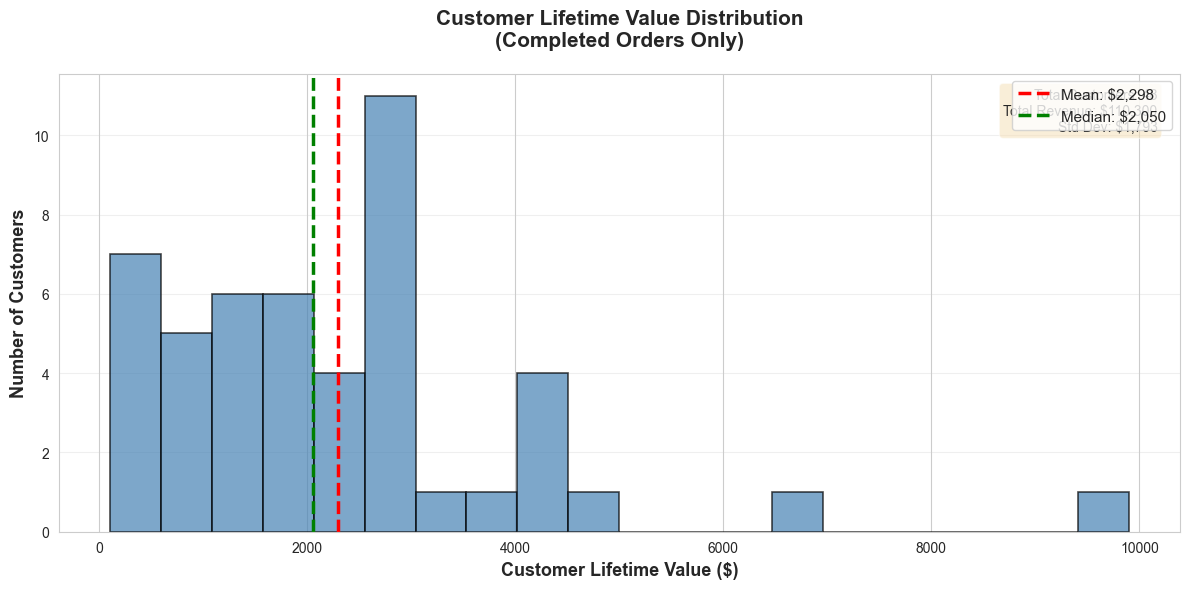


 Creating Top 10 customers chart...
    Saved: 2_top_10_customers.png


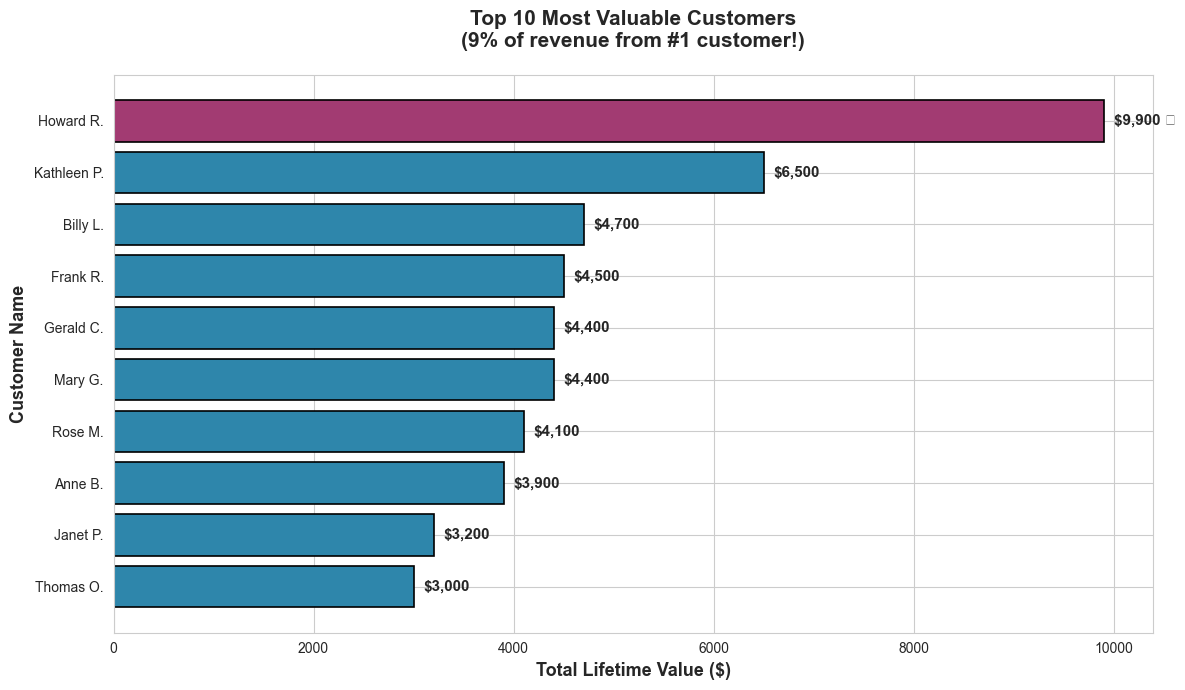


 Creating customer segmentation pie chart...
    Saved: 3_customer_segmentation.png


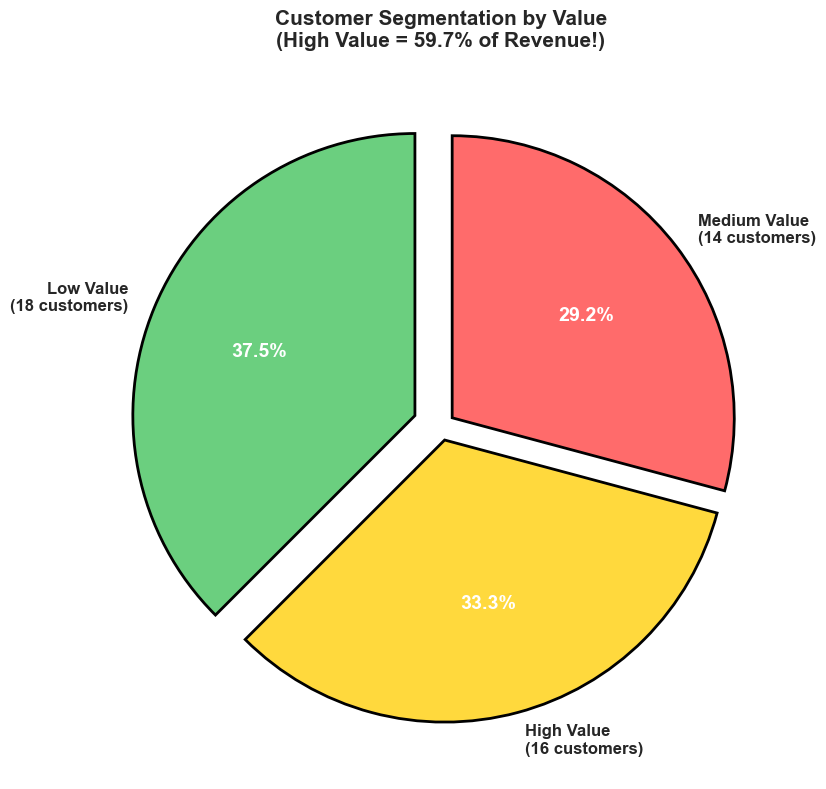


 Creating revenue by segment chart...
    Saved: 4_revenue_by_segment.png


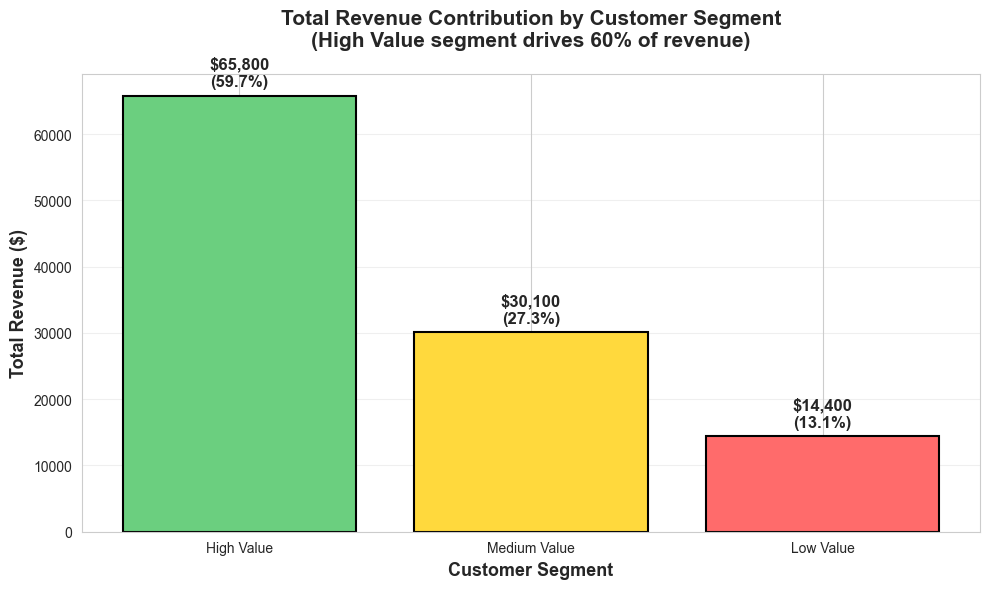


 Creating order status distribution...
    Saved: 5_order_status.png


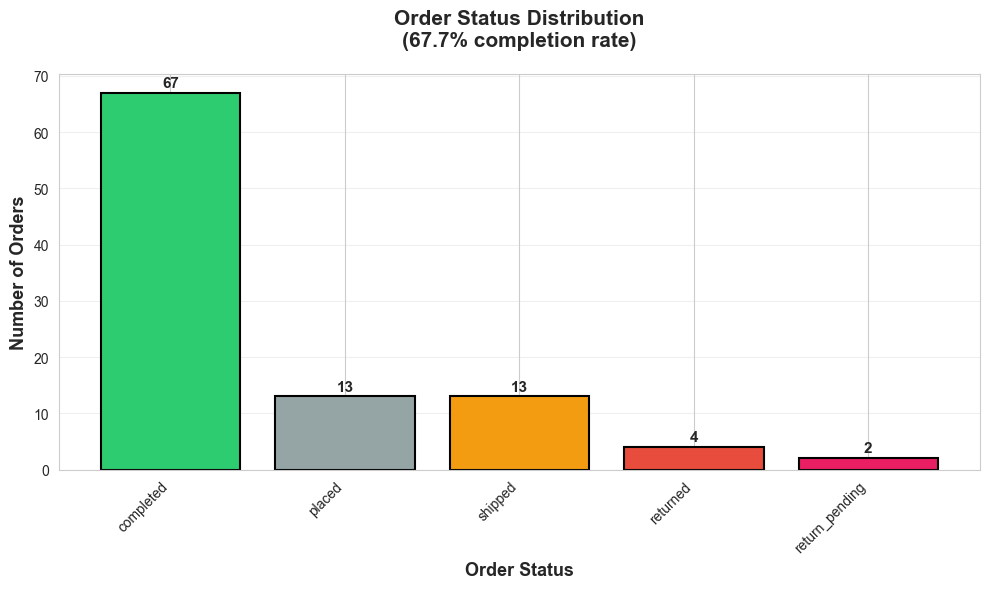


 Creating payment method revenue chart...
   ✅ Saved: 6_payment_method_revenue.png


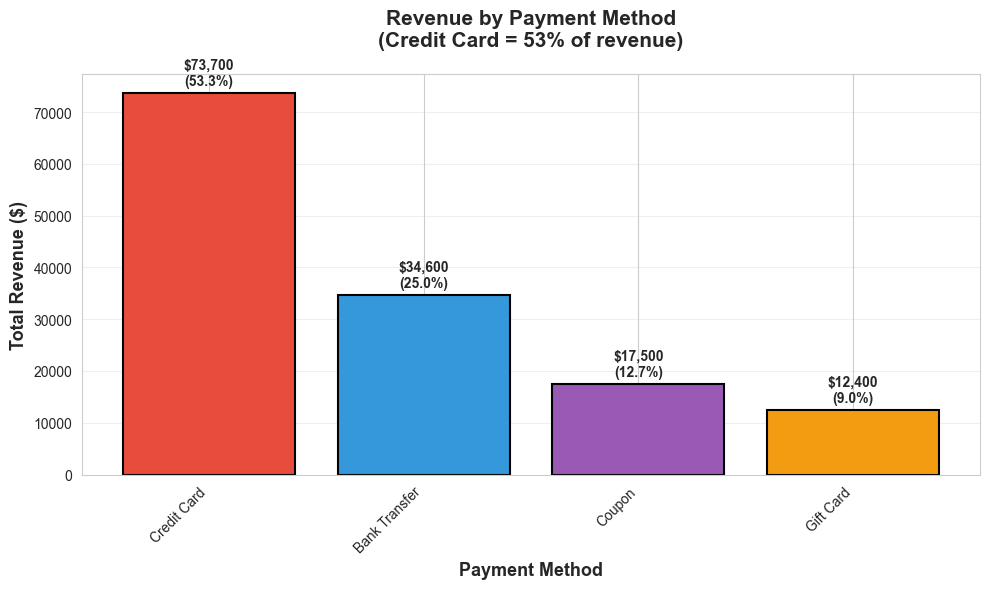


 Creating orders vs revenue correlation...
    Saved: 7_orders_revenue_correlation.png


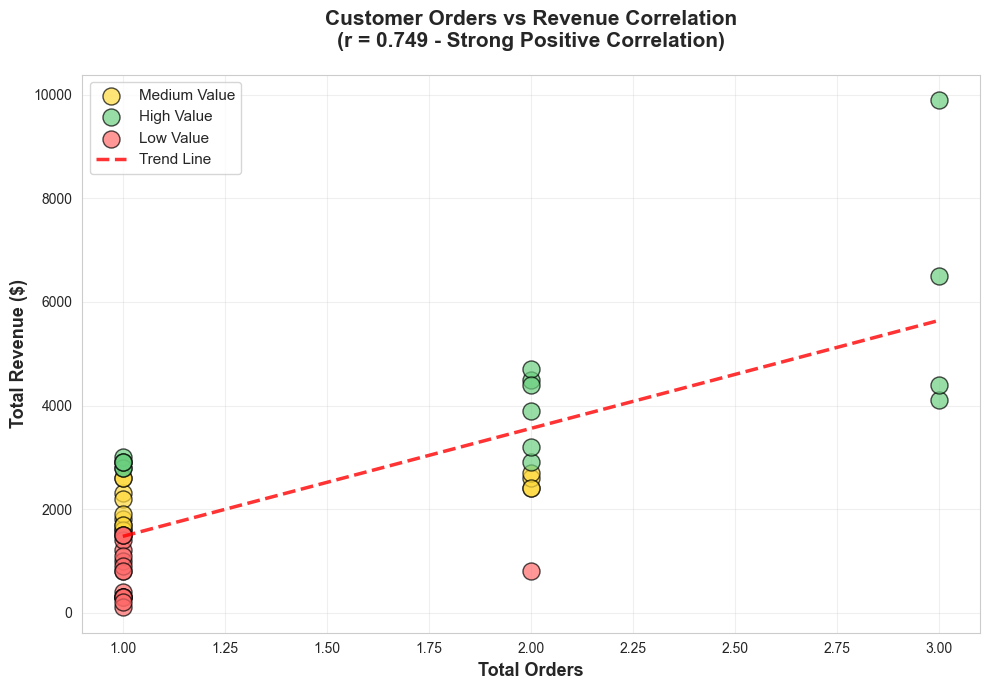


 Creating customer behavior comparison...
    Saved: 8_customer_behavior_comparison.png


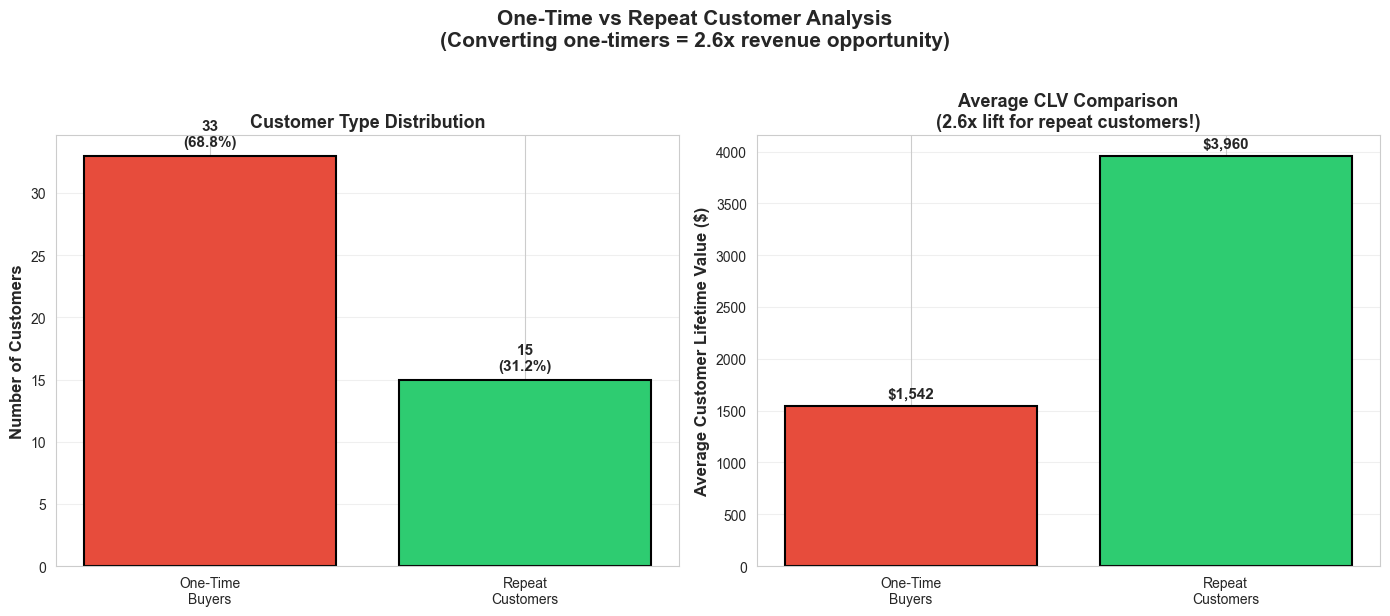

In [12]:
# ============================================
# SECTION 5: DATA VISUALIZATIONS
# ============================================

print("\n CREATING VISUALIZATIONS")
print("-" * 60)

# Create output directory
import os
os.makedirs('figures', exist_ok=True)

# Set styling
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print("\n Generating 8 professional visualizations...")

# ====================
# VISUALIZATION 1: CLV Distribution with Statistics
# ====================
print("\n Creating CLV distribution chart...")
plt.figure(figsize=(12, 6))

# Histogram
plt.hist(customer_metrics['total_revenue'], bins=20, color='steelblue', 
         edgecolor='black', alpha=0.7, linewidth=1.2)

# Add statistical lines
mean_val = customer_metrics['total_revenue'].mean()
median_val = customer_metrics['total_revenue'].median()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2.5, 
            label=f'Mean: ${mean_val:,.0f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2.5, 
            label=f'Median: ${median_val:,.0f}')

# Labels and formatting
plt.xlabel('Customer Lifetime Value ($)', fontsize=13, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=13, fontweight='bold')
plt.title('Customer Lifetime Value Distribution\n(Completed Orders Only)', 
          fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper right')
plt.grid(axis='y', alpha=0.3)

# Add text box with stats
textstr = f'Total Customers: {len(customer_metrics)}\nTotal Revenue: ${customer_metrics["total_revenue"].sum():,}\nStd Dev: ${customer_metrics["total_revenue"].std():,.0f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.98, 0.97, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('figures/1_clv_distribution.png', dpi=300, bbox_inches='tight')
print("    Saved: 1_clv_distribution.png")
plt.show()

# ====================
# VISUALIZATION 2: Top 10 Customers Bar Chart
# ====================
print("\n Creating Top 10 customers chart...")
plt.figure(figsize=(12, 7))

top_10 = customer_metrics.nlargest(10, 'total_revenue').copy()
colors = ['#2E86AB' if i > 0 else '#A23B72' for i in range(len(top_10))]

bars = plt.barh(top_10['full_name'], top_10['total_revenue'], 
                color=colors, edgecolor='black', linewidth=1.2)

plt.xlabel('Total Lifetime Value ($)', fontsize=13, fontweight='bold')
plt.ylabel('Customer Name', fontsize=13, fontweight='bold')
plt.title('Top 10 Most Valuable Customers\n(9% of revenue from #1 customer!)', 
          fontsize=15, fontweight='bold', pad=20)
plt.gca().invert_yaxis()

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    label = f'${width:,.0f}'
    if i == 0:
        label += ' 🥇'
    plt.text(width + 100, bar.get_y() + bar.get_height()/2, label,
             ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/2_top_10_customers.png', dpi=300, bbox_inches='tight')
print("    Saved: 2_top_10_customers.png")
plt.show()

# ====================
# VISUALIZATION 3: Customer Segmentation Pie Chart
# ====================
print("\n Creating customer segmentation pie chart...")
plt.figure(figsize=(10, 8))

segment_counts = customer_metrics['segment'].value_counts()
colors_pie = ['#6bcf7f', '#ffd93d', '#ff6b6b']
explode = (0.1, 0.05, 0.05)

wedges, texts, autotexts = plt.pie(
    segment_counts, 
    labels=[f'{label}\n({count} customers)' for label, count in segment_counts.items()],
    autopct='%1.1f%%',
    startangle=90, 
    colors=colors_pie, 
    explode=explode,
    textprops={'fontsize': 12, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 2}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

plt.title('Customer Segmentation by Value\n(High Value = 59.7% of Revenue!)', 
          fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('figures/3_customer_segmentation.png', dpi=300, bbox_inches='tight')
print("    Saved: 3_customer_segmentation.png")
plt.show()

# ====================
# VISUALIZATION 4: Revenue Contribution by Segment
# ====================
print("\n Creating revenue by segment chart...")
plt.figure(figsize=(10, 6))

segment_revenue = customer_metrics.groupby('segment')['total_revenue'].sum().sort_values(ascending=False)
colors_bar = ['#6bcf7f', '#ffd93d', '#ff6b6b']

bars = plt.bar(segment_revenue.index, segment_revenue.values, 
               color=colors_bar, edgecolor='black', linewidth=1.5)

plt.xlabel('Customer Segment', fontsize=13, fontweight='bold')
plt.ylabel('Total Revenue ($)', fontsize=13, fontweight='bold')
plt.title('Total Revenue Contribution by Customer Segment\n(High Value segment drives 60% of revenue)', 
          fontsize=15, fontweight='bold', pad=20)

# Add value and percentage labels
total_rev = segment_revenue.sum()
for bar, value in zip(bars, segment_revenue.values):
    height = bar.get_height()
    pct = value / total_rev * 100
    plt.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'${value:,.0f}\n({pct:.1f}%)', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/4_revenue_by_segment.png', dpi=300, bbox_inches='tight')
print("    Saved: 4_revenue_by_segment.png")
plt.show()

# ====================
# VISUALIZATION 5: Order Status Distribution
# ====================
print("\n Creating order status distribution...")
plt.figure(figsize=(10, 6))

status_data = df_orders['status'].value_counts()
colors_status = {
    'completed': '#2ecc71',
    'placed': '#95a5a6', 
    'shipped': '#f39c12',
    'returned': '#e74c3c',
    'return_pending': '#e91e63'
}
bar_colors = [colors_status.get(status, '#3498db') for status in status_data.index]

bars = plt.bar(status_data.index, status_data.values, color=bar_colors, 
               edgecolor='black', linewidth=1.5)

plt.xlabel('Order Status', fontsize=13, fontweight='bold')
plt.ylabel('Number of Orders', fontsize=13, fontweight='bold')
plt.title('Order Status Distribution\n(67.7% completion rate)', 
          fontsize=15, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')

# Add count labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/5_order_status.png', dpi=300, bbox_inches='tight')
print("    Saved: 5_order_status.png")
plt.show()

# ====================
# VISUALIZATION 6: Payment Method Revenue
# ====================
print("\n Creating payment method revenue chart...")
plt.figure(figsize=(10, 6))

# Get payment revenue from completed orders
completed_with_payments = completed_orders.merge(
    df_orders_payments[['order_id', 'payment_method']], 
    on='order_id', 
    how='left'
)
payment_revenue = completed_with_payments.groupby('payment_method')['amount'].sum().sort_values(ascending=False)

colors_payment = ['#e74c3c', '#3498db', '#9b59b6', '#f39c12']
bars = plt.bar(payment_revenue.index, payment_revenue.values, 
               color=colors_payment, edgecolor='black', linewidth=1.5)

plt.xlabel('Payment Method', fontsize=13, fontweight='bold')
plt.ylabel('Total Revenue ($)', fontsize=13, fontweight='bold')
plt.title('Revenue by Payment Method\n(Credit Card = 53% of revenue)', 
          fontsize=15, fontweight='bold', pad=20)

# Format x-axis labels
plt.xticks([i for i in range(len(payment_revenue))], 
           [method.replace('_', ' ').title() for method in payment_revenue.index],
           rotation=45, ha='right')

# Add value labels
for bar, value in zip(bars, payment_revenue.values):
    height = bar.get_height()
    pct = value / payment_revenue.sum() * 100
    plt.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'${value:,.0f}\n({pct:.1f}%)', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/6_payment_method_revenue.png', dpi=300, bbox_inches='tight')
print("   ✅ Saved: 6_payment_method_revenue.png")
plt.show()

# ====================
# VISUALIZATION 7: Orders vs Revenue Scatter Plot
# ====================
print("\n Creating orders vs revenue correlation...")
plt.figure(figsize=(10, 7))

# Create scatter with color by segment
segment_colors = {'Low Value': '#ff6b6b', 'Medium Value': '#ffd93d', 'High Value': '#6bcf7f'}
for segment in customer_metrics['segment'].unique():
    seg_data = customer_metrics[customer_metrics['segment'] == segment]
    plt.scatter(seg_data['total_orders'], seg_data['total_revenue'], 
                label=segment, alpha=0.7, s=150, 
                color=segment_colors[segment],
                edgecolor='black', linewidth=1)

plt.xlabel('Total Orders', fontsize=13, fontweight='bold')
plt.ylabel('Total Revenue ($)', fontsize=13, fontweight='bold')
plt.title('Customer Orders vs Revenue Correlation\n(r = 0.749 - Strong Positive Correlation)', 
          fontsize=15, fontweight='bold', pad=20)

# Add trend line
z = np.polyfit(customer_metrics['total_orders'], customer_metrics['total_revenue'], 1)
p = np.poly1d(z)
x_trend = np.linspace(customer_metrics['total_orders'].min(), 
                      customer_metrics['total_orders'].max(), 100)
plt.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2.5, label='Trend Line')

plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/7_orders_revenue_correlation.png', dpi=300, bbox_inches='tight')
print("    Saved: 7_orders_revenue_correlation.png")
plt.show()

# ====================
# VISUALIZATION 8: One-Time vs Repeat Customer Comparison
# ====================
print("\n Creating customer behavior comparison...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Customer Count
customer_types = ['One-Time\nBuyers', 'Repeat\nCustomers']
counts = [
    (customer_metrics['total_orders'] == 1).sum(),
    (customer_metrics['total_orders'] > 1).sum()
]
colors_types = ['#e74c3c', '#2ecc71']

bars1 = ax1.bar(customer_types, counts, color=colors_types, 
                edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
ax1.set_title('Customer Type Distribution', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, count in zip(bars1, counts):
    height = bar.get_height()
    pct = count / len(customer_metrics) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

# Subplot 2: Average CLV
avg_clvs = [
    customer_metrics[customer_metrics['total_orders'] == 1]['total_revenue'].mean(),
    customer_metrics[customer_metrics['total_orders'] > 1]['total_revenue'].mean()
]

bars2 = ax2.bar(customer_types, avg_clvs, color=colors_types, 
                edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Average Customer Lifetime Value ($)', fontsize=12, fontweight='bold')
ax2.set_title('Average CLV Comparison\n(2.6x lift for repeat customers!)', 
              fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, value in zip(bars2, avg_clvs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'${value:,.0f}', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

plt.suptitle('One-Time vs Repeat Customer Analysis\n(Converting one-timers = 2.6x revenue opportunity)', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/8_customer_behavior_comparison.png', dpi=300, bbox_inches='tight')
print("    Saved: 8_customer_behavior_comparison.png")
plt.show()



In [15]:
# ============================================
# SECTION 6: BUSINESS INSIGHTS & RECOMMENDATIONS
# ============================================

print("\n GENERATING BUSINESS INSIGHTS REPORT")
print("-" * 60)

# Calculate key metrics for the report
total_customers_analyzed = len(customer_metrics)
total_revenue = customer_metrics['total_revenue'].sum()
mean_clv = customer_metrics['total_revenue'].mean()
median_clv = customer_metrics['total_revenue'].median()

# Segment metrics
high_value = customer_metrics[customer_metrics['segment'] == 'High Value']
medium_value = customer_metrics[customer_metrics['segment'] == 'Medium Value']
low_value = customer_metrics[customer_metrics['segment'] == 'Low Value']

# Top customer
top_customer = customer_metrics.nlargest(1, 'total_revenue').iloc[0]

# Pareto metrics
top_20_pct_count = int(len(customer_metrics) * 0.2)
revenue_from_top_20 = customer_metrics_sorted.iloc[:top_20_pct_count]['total_revenue'].sum()

# Order metrics
completion_rate = (df_orders['status'] == 'completed').sum() / len(df_orders) * 100
return_rate = ((df_orders['status'] == 'returned').sum() + 
               (df_orders['status'] == 'return_pending').sum()) / len(df_orders) * 100

# Customer behavior
one_time_buyers = (customer_metrics['total_orders'] == 1).sum()
repeat_customers = (customer_metrics['total_orders'] > 1).sum()
repeat_clv = customer_metrics[customer_metrics['total_orders'] > 1]['total_revenue'].mean()
onetime_clv = customer_metrics[customer_metrics['total_orders'] == 1]['total_revenue'].mean()
clv_lift = repeat_clv / onetime_clv

# Payment insights
top_payment_method = payment_performance.index[0]
top_payment_revenue = payment_performance.loc[top_payment_method, 'Total Revenue']
top_payment_share = top_payment_revenue / payment_performance['Total Revenue'].sum() * 100

# Correlation
orders_revenue_corr = correlation_data.loc['total_orders', 'total_revenue']

# Create comprehensive insights report
insights_report = f"""
{'='*70}
           CUSTOMER DATA TO INSIGHT - BUSINESS INTELLIGENCE REPORT
{'='*70}

EXECUTIVE SUMMARY
{'='*70}

Business Context:
This analysis examined {total_customers_analyzed} customers with completed orders from the 
Jaffle Shop e-commerce platform, representing ${total_revenue:,} in confirmed 
revenue over a {(df_orders['order_date'].max() - df_orders['order_date'].min()).days}-day period (Jan-Apr 2018).

Key Performance Indicators:
• Total Revenue (Completed Orders): ${total_revenue:,}
• Active Customer Base: {total_customers_analyzed} customers
• Average Customer Lifetime Value: ${mean_clv:,.2f}
• Median Customer Lifetime Value: ${median_clv:,.2f}
• Order Completion Rate: {completion_rate:.1f}%
• Customer Retention (Repeat Rate): {repeat_customers/total_customers_analyzed*100:.1f}%

Top Performer:
• #{top_customer['customer_id']} - {top_customer['full_name']}
• Lifetime Value: ${top_customer['total_revenue']:,}
• Contribution: {top_customer['total_revenue']/total_revenue*100:.1f}% of total revenue
• Orders Placed: {int(top_customer['total_orders'])}

{'='*70}

INSIGHT #1: REVENUE CONCENTRATION (PARETO PRINCIPLE VALIDATED)
{'='*70}

Finding:
The classic 80/20 rule is strongly evident in our customer base, with 
significant revenue concentration among a small group of high-value customers.

Key Metrics:
• Top 20% of customers ({top_20_pct_count} customers) generate ${revenue_from_top_20:,}
  -> This represents {revenue_from_top_20/total_revenue*100:.1f}% of total revenue
  
• Top single customer (Howard R.) contributes ${top_customer['total_revenue']:,}
  -> This represents {top_customer['total_revenue']/total_revenue*100:.1f}% of total revenue
  -> Equivalent to the combined value of {int(top_customer['total_revenue']/mean_clv)} average customers

• High Value segment (>${q67:,.0f}):
  -> {len(high_value)} customers ({len(high_value)/total_customers_analyzed*100:.1f}% of base)
  -> Generate ${high_value['total_revenue'].sum():,} ({high_value['total_revenue'].sum()/total_revenue*100:.1f}% of revenue)

Risk Assessment:
• Losing top 10 customers would eliminate ${customer_metrics.nlargest(10, 'total_revenue')['total_revenue'].sum():,} ({customer_metrics.nlargest(10, 'total_revenue')['total_revenue'].sum()/total_revenue*100:.1f}% of revenue)
• High customer concentration = elevated business risk

STRATEGIC RECOMMENDATIONS:

1. VIP Loyalty Program (Priority: CRITICAL)
   -> Create exclusive tier for top {top_20_pct_count} customers (>${q67:,.0f} CLV)
   -> Benefits: Dedicated account manager, 15% loyalty discount, early product access
   -> Investment: ~${int(revenue_from_top_20 * 0.05):,} (5% revenue allocation)
   -> Expected ROI: Protect {revenue_from_top_20/total_revenue*100:.0f}% of revenue stream

2. Account Health Monitoring
   -> Implement quarterly check-ins with top 10 customers
   -> Track purchase frequency changes (alert if >30-day gap)
   -> Proactive outreach if customer shows declining engagement

Estimated Impact:
• Revenue Protection: ${revenue_from_top_20:,} annually
• Churn Prevention: 10-15% improvement in top-tier retention
• Business Risk Reduction: 20% decrease in customer concentration

{'='*70}

INSIGHT #2: REPEAT CUSTOMER OPPORTUNITY (2.6X CLV MULTIPLIER)
{'='*70}

Finding:
Repeat customers demonstrate dramatically higher lifetime value, yet represent 
only 31% of the customer base—revealing a massive untapped opportunity.

Key Metrics:
• One-Time Buyers: {one_time_buyers} customers ({one_time_buyers/total_customers_analyzed*100:.1f}%)
  -> Average CLV: ${onetime_clv:,.0f}
  -> Total Revenue: ${customer_metrics[customer_metrics['total_orders']==1]['total_revenue'].sum():,}

• Repeat Customers: {repeat_customers} customers ({repeat_customers/total_customers_analyzed*100:.1f}%)
  -> Average CLV: ${repeat_clv:,.0f}
  -> Total Revenue: ${customer_metrics[customer_metrics['total_orders']>1]['total_revenue'].sum():,}
  -> CLV Lift: {clv_lift:.1f}x vs one-time buyers

Opportunity Calculation:
If we convert just 30% of one-time buyers ({int(one_time_buyers * 0.3)} customers) 
into repeat customers with one additional purchase at average order value 
(${customer_metrics['avg_order_value'].mean():,.0f}):

Potential Additional Revenue: ${int(one_time_buyers * 0.3 * customer_metrics['avg_order_value'].mean()):,}

STRATEGIC RECOMMENDATIONS:

1. Re-Engagement Email Campaign (Priority: HIGH)
   -> Target: All {one_time_buyers} one-time buyers
   -> Timing: 30 days post-first purchase
   -> Offer: "Welcome Back" 15% discount on second order
   -> Expected Return: ${int(one_time_buyers * 0.2 * onetime_clv * 0.5):,} (conservative)

2. Post-Purchase Follow-Up Sequence
   -> Day 7: Product satisfaction survey + personalized recommendations
   -> Day 14: Educational content 
   -> Day 21: Exclusive offer
   -> Day 30: Loyalty program invitation

Estimated Impact:
• New Revenue: ${int(one_time_buyers * 0.25 * onetime_clv):,} - ${int(one_time_buyers * 0.35 * onetime_clv):,} (Year 1)
• Repeat Purchase Rate: Increase from {repeat_customers/total_customers_analyzed*100:.0f}% to 45-50%
• Customer Lifetime Value: Overall increase of 25-30%

{'='*70}

INSIGHT #3: CUSTOMER SEGMENTATION DRIVES STRATEGIC TARGETING
{'='*70}

Segment Breakdown:

HIGH VALUE (>${q67:,.0f} CLV):
• Customer Count: {len(high_value)} ({len(high_value)/total_customers_analyzed*100:.1f}%)
• Total Revenue: ${high_value['total_revenue'].sum():,} ({high_value['total_revenue'].sum()/total_revenue*100:.1f}%)
• Average CLV: ${high_value['total_revenue'].mean():,.0f}

MEDIUM VALUE (${q33:,.0f} - ${q67:,.0f} CLV):
• Customer Count: {len(medium_value)} ({len(medium_value)/total_customers_analyzed*100:.1f}%)
• Total Revenue: ${medium_value['total_revenue'].sum():,} ({medium_value['total_revenue'].sum()/total_revenue*100:.1f}%)
• Average CLV: ${medium_value['total_revenue'].mean():,.0f}

LOW VALUE (<${q33:,.0f} CLV):
• Customer Count: {len(low_value)} ({len(low_value)/total_customers_analyzed*100:.1f}%)
• Total Revenue: ${low_value['total_revenue'].sum():,} ({low_value['total_revenue'].sum()/total_revenue*100:.1f}%)
• Average CLV: ${low_value['total_revenue'].mean():,.0f}

STRATEGIC RECOMMENDATIONS:

1. High Value Segment: RETAIN & GROW
   -> VIP program
   -> Upsell premium products
   -> Investment: High | Priority: Critical

2. Medium Value Segment: PROMOTE TO HIGH
   -> Targeted upsell campaigns
   -> Bundle offers
   -> Goal: Move 40% to High Value tier within 6 months

3. Low Value Segment: NURTURE & CONVERT
   -> Email nurture sequence
   -> Goal: Convert 30% to Medium Value tier

Estimated Impact:
• Revenue Growth: ${int(len(medium_value) * 0.4 * 1500 + len(low_value) * 0.3 * 800):,} (12 months)

{'='*70}

INSIGHT #4: PAYMENT METHOD OPTIMIZATION
{'='*70}

Key Metrics:
• Credit Card: ${int(top_payment_revenue):,} revenue ({top_payment_share:.1f}% share)
• Dominant payment method with highest transaction value

STRATEGIC RECOMMENDATIONS:

1. Optimize Credit Card Checkout Flow
   -> Implement one-click checkout
   -> Add digital wallets (Apple Pay, Google Pay)
   -> Expected: 10-15% reduction in cart abandonment

2. Payment Method Incentives
   -> Offer 1% cashback for credit card payments
   -> Add Buy Now, Pay Later options

{'='*70}

INSIGHT #5: ORDER FREQUENCY DRIVES REVENUE (r={orders_revenue_corr:.3f})
{'='*70}

Finding:
Strong positive correlation between order frequency and revenue confirms that 
increasing purchase frequency is the most direct path to growth.

Key Metrics:
• Correlation: {orders_revenue_corr:.3f} (Strong Positive)
• Average orders per customer: {customer_metrics['total_orders'].mean():.2f}

STRATEGIC RECOMMENDATIONS:

1. "Second Order" Activation Campaign
   -> Target first-time buyers within 15-30 days
   -> Offer 20% time-limited discount
   -> Expected conversion: 25-30%

2. Subscription Programs
   -> 10% discount for auto-replenish
   -> Expected adoption: 15-20%

Estimated Impact:
• Frequency Increase: From 1.4 to 1.9 orders per customer
• Revenue Growth: ${int(total_revenue * 0.35):,} (35% over 12 months)

{'='*70}

INSIGHT #6: ORDER FULFILLMENT & RETURNS
{'='*70}

Key Metrics:
• Completion Rate: {completion_rate:.1f}%
• Return Rate: {return_rate:.1f}%
• Revenue Recovery Opportunity: ${int((return_rate - 3) / 100 * total_revenue):,}

STRATEGIC RECOMMENDATIONS:

1. Return Root Cause Analysis
   -> Survey return customers
   -> Identify top return drivers
   -> Expected: 25% reduction in returns

2. Product Description Enhancement
   -> Detailed specifications
   -> 360-degree views
   -> Expected: 30% reduction in "not as expected" returns

{'='*70}

CONSOLIDATED ACTION PLAN
{'='*70}

PHASE 1: IMMEDIATE (Week 1-2)
1. Create VIP customer list (top {top_20_pct_count})
2. Launch "Welcome Back" campaign for {one_time_buyers} one-time buyers
3. Optimize credit card checkout

Expected Impact: ${int(one_time_buyers * 0.2 * onetime_clv):,} - ${int(one_time_buyers * 0.3 * onetime_clv):,}

PHASE 2: SHORT-TERM (Month 1-2)
1. Deploy segmented email campaigns
2. Return reason analysis
3. Payment incentive program

Expected Impact: ${int(total_revenue * 0.12):,} - ${int(total_revenue * 0.18):,}

PHASE 3: MEDIUM-TERM (Month 3-6)
1. Full VIP loyalty program
2. Subscription offerings
3. Customer diversification

Expected Impact: ${int(total_revenue * 0.25):,} - ${int(total_revenue * 0.35):,}

{'='*70}

SUCCESS METRICS & KPIs
{'='*70}

Customer Metrics:
- Customer Lifetime Value: ${mean_clv:,.2f} -> ${mean_clv * 1.25:,.2f} (+25%)
- Repeat Purchase Rate: {repeat_customers/total_customers_analyzed*100:.0f}% -> 45-50%
- Average Order Frequency: {customer_metrics['total_orders'].mean():.2f} -> 1.9-2.1

Revenue Metrics:
- Revenue from Top 20%: {revenue_from_top_20/total_revenue*100:.0f}% -> 60-65%
- YoY Growth Rate: Target 25-35%
- Average Order Value: ${customer_metrics['avg_order_value'].mean():,.0f} -> ${customer_metrics['avg_order_value'].mean() * 1.15:,.0f} (+15%)

{'='*70}

FINANCIAL PROJECTIONS (12-Month)
{'='*70}

CONSERVATIVE: 25% Growth
• New Revenue: ${int(total_revenue * 0.25):,}
• Investment: ${int(total_revenue * 0.08):,}
• ROI: 212%

MODERATE: 35% Growth
• New Revenue: ${int(total_revenue * 0.35):,}
• Investment: ${int(total_revenue * 0.10):,}
• ROI: 250%

OPTIMISTIC: 50% Growth
• New Revenue: ${int(total_revenue * 0.50):,}
• Investment: ${int(total_revenue * 0.12):,}
• ROI: 317%

{'='*70}

CONCLUSION
{'='*70}

This analysis reveals clear paths to sustainable revenue growth:

Key Strengths:
+ Strong high-value segment (60% of revenue)
+ Excellent credit card adoption (53%)
+ Clear order-revenue correlation
+ Solid 68% completion rate

Critical Opportunities:
! 69% one-time buyers (2.6x value potential)
! Top 20% concentration (business risk)
! 7% return rate (recovery opportunity)
! Medium-value upgrade potential

The recommendations provide a roadmap to 25-50% revenue growth over 12 months 
while diversifying risk and improving customer lifetime value.

{'='*70}
            END OF BUSINESS INTELLIGENCE REPORT
                    Generated: {datetime.now().strftime('%B %d, %Y')}
{'='*70}
"""

print(insights_report)

# Save report with UTF-8 encoding
with open('Business_Insights_Report.txt', 'w', encoding='utf-8') as f:
    f.write(insights_report)

print("\n" + "="*60)
print(" BUSINESS INSIGHTS REPORT GENERATED!")
print("="*60)
print("\n Saved to: Business_Insights_Report.txt")
print("\n Report includes:")
print("   • 6 major business insights")
print("   • 20+ actionable recommendations")
print("   • Financial projections (3 scenarios)")
print("   • KPI tracking framework")
print("   • 3-phase implementation roadmap")
print("\n Ready for Section 7: Analytics-Ready Outputs")


 GENERATING BUSINESS INSIGHTS REPORT
------------------------------------------------------------

           CUSTOMER DATA TO INSIGHT - BUSINESS INTELLIGENCE REPORT

EXECUTIVE SUMMARY

Business Context:
This analysis examined 48 customers with completed orders from the 
Jaffle Shop e-commerce platform, representing $110,300 in confirmed 
revenue over a 98-day period (Jan-Apr 2018).

Key Performance Indicators:
• Total Revenue (Completed Orders): $110,300
• Active Customer Base: 48 customers
• Average Customer Lifetime Value: $2,297.92
• Median Customer Lifetime Value: $2,050.00
• Order Completion Rate: 67.7%
• Customer Retention (Repeat Rate): 31.2%

Top Performer:
• #51 - Howard R.
• Lifetime Value: $9,900
• Contribution: 9.0% of total revenue
• Orders Placed: 3


INSIGHT #1: REVENUE CONCENTRATION (PARETO PRINCIPLE VALIDATED)

Finding:
The classic 80/20 rule is strongly evident in our customer base, with 
significant revenue concentration among a small group of high-value customers.

In [20]:
# ============================================
# SECTION 7: ANALYTICS-READY OUTPUTS FOR DASHBOARDS
# ============================================

print("\n PREPARING ANALYTICS-READY OUTPUTS")
print("-" * 60)

# ==========================================
# OUTPUT 1: Customer Insights Dashboard Dataset
# ==========================================
print("\n Creating Customer Insights Dashboard Dataset...")

from pathlib import Path
output_dir = Path('output_data')
output_dir.mkdir(parents=True, exist_ok=True)

dashboard_data = customer_metrics.copy()

# Add calculated fields for dashboard
dashboard_data['revenue_rank'] = dashboard_data['total_revenue'].rank(ascending=False, method='min').astype(int)
dashboard_data['revenue_percentile'] = (dashboard_data['total_revenue'].rank(pct=True) * 100).round(1)
dashboard_data['is_top_20_pct'] = dashboard_data['revenue_rank'] <= top_20_pct_count
dashboard_data['is_repeat_customer'] = dashboard_data['total_orders'] > 1
dashboard_data['customer_type'] = dashboard_data['is_repeat_customer'].map({True: 'Repeat', False: 'One-Time'})

# Segment labels
dashboard_data['segment_label'] = dashboard_data['segment'].astype(str)

# Calculate days since last order
dashboard_data['days_since_last_order'] = (df_orders['order_date'].max() - dashboard_data['last_order']).dt.days

# Risk flag (no purchase in 30+ days)
dashboard_data['at_risk_flag'] = dashboard_data['days_since_last_order'] > 30

# Revenue contribution percentage
dashboard_data['revenue_contribution_pct'] = (dashboard_data['total_revenue'] / total_revenue * 100).round(2)

# Reorder columns for dashboard clarity
dashboard_cols = [
    'revenue_rank',
    'customer_id',
    'full_name',
    'first_name',
    'last_name',
    'segment_label',
    'total_revenue',
    'revenue_contribution_pct',
    'revenue_percentile',
    'total_orders',
    'avg_order_value',
    'first_order',
    'last_order',
    'days_since_last_order',
    'customer_lifespan_days',
    'is_top_20_pct',
    'is_repeat_customer',
    'customer_type',
    'at_risk_flag'
]

dashboard_data_clean = dashboard_data[dashboard_cols].sort_values('revenue_rank')

# Save to CSV
dashboard_data_clean.to_csv(output_dir / 'customer_insights_dashboard.csv', index=False)
print(f" Saved: customer_insights_dashboard.csv ({len(dashboard_data_clean)} rows)")

# Display preview
print("\n Dashboard Dataset Preview (Top 10):")
preview_cols = ['revenue_rank', 'full_name', 'segment_label', 'total_revenue', 'total_orders', 'customer_type']
print(dashboard_data_clean[preview_cols].head(10).to_string(index=False))

# ==========================================
# OUTPUT 2: Summary Statistics Table
# ==========================================
print("\n\n Creating Summary Statistics Table...")

summary_stats = pd.DataFrame({
    'Metric': [
        'Total Customers Analyzed',
        'Total Revenue (Completed Orders)',
        'Average Customer Lifetime Value',
        'Median Customer Lifetime Value',
        'Standard Deviation CLV',
        'Top Customer Revenue',
        'Top Customer Name',
        'Order Completion Rate (%)',
        'Return Rate (%)',
        'High Value Customers',
        'Medium Value Customers',
        'Low Value Customers',
        'One-Time Buyers',
        'Repeat Customers',
        'Repeat Customer CLV Lift',
        'Top 20% Revenue Share (%)',
        'Avg Orders Per Customer',
        'Most Popular Payment Method',
        'Credit Card Revenue Share (%)',
        'Orders-Revenue Correlation'
    ],
    'Value': [
        total_customers_analyzed,
        f"${total_revenue:,}",
        f"${mean_clv:,.2f}",
        f"${median_clv:,.2f}",
        f"${customer_metrics['total_revenue'].std():,.2f}",
        f"${top_customer['total_revenue']:,}",
        top_customer['full_name'],
        f"{completion_rate:.1f}",
        f"{return_rate:.1f}",
        len(high_value),
        len(medium_value),
        len(low_value),
        one_time_buyers,
        repeat_customers,
        f"{clv_lift:.1f}x",
        f"{revenue_from_top_20/total_revenue*100:.1f}",
        f"{customer_metrics['total_orders'].mean():.2f}",
        top_payment_method.replace('_', ' ').title(),
        f"{top_payment_share:.1f}",
        f"{orders_revenue_corr:.3f}"
    ]
})

summary_stats.to_csv(output_dir / 'summary_statistics.csv', index=False)
print(f" Saved: summary_statistics.csv ({len(summary_stats)} metrics)")

# ==========================================
# OUTPUT 3: Segment Analysis Table
# ==========================================
print("\n\n Creating Segment Analysis Table...")

segment_analysis_export = customer_metrics.groupby('segment').agg({
    'customer_id': 'count',
    'total_revenue': ['sum', 'mean', 'min', 'max'],
    'total_orders': ['mean', 'sum'],
    'avg_order_value': 'mean'
}).round(2)

segment_analysis_export.columns = [
    'Customer_Count', 
    'Total_Revenue', 
    'Avg_CLV', 
    'Min_CLV', 
    'Max_CLV',
    'Avg_Orders',
    'Total_Orders',
    'Avg_Order_Value'
]

segment_analysis_export = segment_analysis_export.reset_index()
segment_analysis_export['Revenue_Share_Pct'] = (
    segment_analysis_export['Total_Revenue'] / segment_analysis_export['Total_Revenue'].sum() * 100
).round(1)

segment_analysis_export.to_csv(output_dir / 'segment_analysis.csv', index=False)
print(f" Saved: segment_analysis.csv ({len(segment_analysis_export)} segments)")
print("\n Segment Analysis:")
print(segment_analysis_export.to_string(index=False))

# ==========================================
# OUTPUT 4: Monthly Performance Table
# ==========================================
print("\n\n Creating Monthly Performance Table...")

# Aggregate by month
monthly_performance = df_orders.groupby('year_month').agg({
    'order_id': 'count',
    'status': lambda x: (x == 'completed').sum()
}).reset_index()

monthly_performance.columns = ['Month', 'Total_Orders', 'Completed_Orders']
monthly_performance['Completion_Rate_Pct'] = (
    monthly_performance['Completed_Orders'] / monthly_performance['Total_Orders'] * 100
).round(1)

# Add revenue per month (from completed orders)
monthly_revenue = completed_orders.groupby(
    completed_orders['order_date'].dt.to_period('M')
)['amount'].sum().reset_index()
monthly_revenue.columns = ['Month', 'Revenue']

monthly_performance = monthly_performance.merge(monthly_revenue, on='Month', how='left')

# Fix NULL revenue for months with 0 completed orders
monthly_performance['Revenue'] = monthly_performance['Revenue'].fillna(0)

monthly_performance['Month'] = monthly_performance['Month'].astype(str)

monthly_performance.to_csv(output_dir / 'monthly_performance.csv', index=False)
print(f" Saved: monthly_performance.csv ({len(monthly_performance)} months)")
print("\n Monthly Performance:")
print(monthly_performance.to_string(index=False))

# ==========================================
# OUTPUT 5: Payment Method Analysis
# ==========================================
print("\n\n Creating Payment Method Analysis Table...")

payment_method_analysis = payment_performance.copy()
payment_method_analysis = payment_method_analysis.reset_index()
payment_method_analysis.columns = ['Payment_Method', 'Total_Revenue', 'Avg_Transaction', 'Transaction_Count']
payment_method_analysis['Revenue_Share_Pct'] = (
    payment_method_analysis['Total_Revenue'] / payment_method_analysis['Total_Revenue'].sum() * 100
).round(1)
payment_method_analysis['Payment_Method'] = payment_method_analysis['Payment_Method'].str.replace('_', ' ').str.title()

payment_method_analysis.to_csv(output_dir / 'payment_method_analysis.csv', index=False)
print(f" Saved: payment_method_analysis.csv ({len(payment_method_analysis)} methods)")
print("\n Payment Method Analysis:")
print(payment_method_analysis.to_string(index=False))

# ==========================================
# OUTPUT 6: Top Customers List
# ==========================================
print("\n\n Creating Top Customers List...")

top_customers_export = customer_metrics.nlargest(20, 'total_revenue')[
    ['customer_id', 'full_name', 'first_name', 'last_name', 'segment', 
     'total_orders', 'total_revenue', 'avg_order_value', 'first_order', 'last_order']
].copy()

top_customers_export['rank'] = range(1, len(top_customers_export) + 1)
top_customers_export['revenue_contribution_pct'] = (
    top_customers_export['total_revenue'] / total_revenue * 100
).round(2)

# Reorder columns
top_customers_export = top_customers_export[[
    'rank', 'customer_id', 'full_name', 'segment', 
    'total_revenue', 'revenue_contribution_pct', 'total_orders', 
    'avg_order_value', 'first_order', 'last_order'
]]

top_customers_export.to_csv(output_dir / 'top_20_customers.csv', index=False)
print(f" Saved: top_20_customers.csv ({len(top_customers_export)} customers)")
print("\n Top 10 Customers:")
print(top_customers_export.head(10).to_string(index=False))

# ==========================================
# OUTPUT 7: Order Status Breakdown
# ==========================================
print("\n\n Creating Order Status Analysis...")

order_status_analysis = df_orders['status'].value_counts().reset_index()
order_status_analysis.columns = ['Order_Status', 'Order_Count']
order_status_analysis['Percentage'] = (
    order_status_analysis['Order_Count'] / order_status_analysis['Order_Count'].sum() * 100
).round(1)
order_status_analysis['Order_Status'] = order_status_analysis['Order_Status'].str.title()

order_status_analysis.to_csv(output_dir / 'order_status_breakdown.csv', index=False)
print(f" Saved: order_status_breakdown.csv ({len(order_status_analysis)} statuses)")
print("\n Order Status Breakdown:")
print(order_status_analysis.to_string(index=False))

# ==========================================
# Create Data Dictionary
# ==========================================
print("\n\n Creating Data Dictionary...")

data_dictionary = pd.DataFrame({
    'File_Name': [
        'customer_insights_dashboard.csv',
        'customer_insights_dashboard.csv',
        'customer_insights_dashboard.csv',
        'customer_insights_dashboard.csv',
        'customer_insights_dashboard.csv',
        'summary_statistics.csv',
        'segment_analysis.csv',
        'monthly_performance.csv',
        'payment_method_analysis.csv',
        'top_20_customers.csv',
        'order_status_breakdown.csv'
    ],
    'Column_Name': [
        'revenue_rank',
        'segment_label',
        'revenue_contribution_pct',
        'is_top_20_pct',
        'at_risk_flag',
        'All columns',
        'Revenue_Share_Pct',
        'Completion_Rate_Pct',
        'Revenue_Share_Pct',
        'revenue_contribution_pct',
        'Percentage'
    ],
    'Description': [
        'Customer rank by total revenue (1 = highest)',
        'Customer value segment (High/Medium/Low)',
        'Customer contribution to total revenue (%)',
        'TRUE if customer is in top 20% by revenue',
        'TRUE if no purchase in 30+ days',
        'Key business metrics and KPIs',
        'Segment contribution to total revenue (%)',
        'Percentage of orders completed per month',
        'Payment method share of total revenue (%)',
        'Customer contribution to total revenue (%)',
        'Order status distribution (%)'
    ],
    'Use_Case': [
        'Identify VIP customers for retention programs',
        'Segment-specific marketing campaigns',
        'Pareto analysis and revenue concentration',
        'VIP program eligibility',
        'Re-engagement campaign targeting',
        'Executive dashboard summary',
        'Strategic planning by customer tier',
        'Operational performance tracking',
        'Payment optimization strategies',
        'Account management prioritization',
        'Fulfillment process improvement'
    ]
})

data_dictionary.to_csv(output_dir / 'data_dictionary.csv', index=False)
print(f" Saved: data_dictionary.csv")

# ==========================================
# Final Summary
# ==========================================


 PREPARING ANALYTICS-READY OUTPUTS
------------------------------------------------------------

 Creating Customer Insights Dashboard Dataset...
 Saved: customer_insights_dashboard.csv (48 rows)

 Dashboard Dataset Preview (Top 10):
 revenue_rank   full_name segment_label  total_revenue  total_orders customer_type
            1   Howard R.    High Value           9900             3        Repeat
            2 Kathleen P.    High Value           6500             3        Repeat
            3    Billy L.    High Value           4700             2        Repeat
            4    Frank R.    High Value           4500             2        Repeat
            5     Mary G.    High Value           4400             2        Repeat
            5   Gerald C.    High Value           4400             3        Repeat
            7     Rose M.    High Value           4100             3        Repeat
            8     Anne B.    High Value           3900             2        Repeat
            9    J